# Preliminary Models --
## With minimal consideration beyond the work of the previous 2 notebooks, we will build and interrogate models to set a baseline standard and gain insight to potentially important features.

Note: I recognize that the workflow I exhibit in this project is somewhat "mixed up" from more "typical" approaches<br> e.g. EDA -> Data Cleaning -> Feature Selection and Engineering -> Modeling. <br><br> However, given the size of the datasets provided and the lack of a domain expert to ask questions, I took a different approach: <br><br>
- First, use feature-importance based feature selection (i.e. Boruta) to focus my attention on meaningful features (notebooks 1 and 2)
- Then, I performed some feature light engineering to improve the usability of the data and to aggregate and merge the supplementary datasets meaningfully (notebooks 1 and 2)
- In the current notebook (notebook 3) I choose to jump straight to machine-learning models to focus my attention even further on important features and to set a benchmark for future modeling that will occur in a future notebook.
<br><br>
- In the next notebook (notebook 4), I will finally perform a more thorough EDA with the intent of developing superior and more informed modeling pipelines (notebook 5).

In [1]:
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from utils.machine_learning import (
    concatenate_model_scores,
    instantiate_column_categories_and_column_imputer,
    instantiate_feature_creation_column_transformer,
    lgbm_baseline_model,
    lgbm_preprocessing,
    log_reg_preprocessing,
    model_assessment,
    rf_preprocessing,
)
from utils.utils import reduce_mem_usage

In [2]:
sns.set_theme(context="notebook", style="white", palette="muted")
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False

In [3]:
pd.set_option("display.float_format", lambda x: f"{x:.5f}")

__Instantiate Useful Column Transformers and Column Groups__

In [4]:
feature_creation, application_flag_columns, ext_sources_columns, cb_inquiry_columns = (
    instantiate_feature_creation_column_transformer()
)

In [5]:
(
    column_imputer,
    num_cols,
    bool_cols,
    cat_cols,
    document_flag_columns,
    housing_object_columns,
    housing_numeric_columns,
    contact_flag_columns,
    cols_to_drop,
    columns_to_drop_boruta_and_corr,
    credit_bureau_columns,
    prev_home_credit_columns,
) = instantiate_column_categories_and_column_imputer()

In [6]:
numeric_columns_boruta = [
    x for x in num_cols if x not in set(columns_to_drop_boruta_and_corr)
]
categorical_columns_boruta = [
    x for x in cat_cols if x not in set(columns_to_drop_boruta_and_corr)
]
boolean_columns_boruta = [
    x for x in bool_cols if x not in set(columns_to_drop_boruta_and_corr)
]

# ----------------

In [7]:
%store -r X_train
X_train = X_train.copy()
%store -r y_train
y_train = y_train.copy()
%store -r X_val
X_val = X_val.copy()
%store -r y_val
y_val = y_val.copy()
%store -r X_test
X_test = X_test.copy()
%store -r y_test
y_test = y_test.copy()

In [8]:
kaggle_X_test = reduce_mem_usage(
    pd.read_csv("../data/original_data/application_test.csv")
)
print("Number of loan applications:", kaggle_X_test.shape[0])
print("Number of features:", kaggle_X_test.shape[1])
kaggle_X_test

Memory usage before optimization: 45.00 MB


Optimizing columns: 100%|██████████| 121/121 [00:00<00:00, 1101.41it/s]

Memory usage after optimization: 14.60 MB
Decreased by 67.6%
Number of loan applications: 48744
Number of features: 121


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.00000,568800.00000,20560.50000,450000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,100005,Cash loans,M,N,Y,0,99000.00000,222768.00000,17370.00000,180000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000
2,100013,Cash loans,M,Y,Y,0,202500.00000,663264.00000,69777.00000,630000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,1.00000,4.00000
3,100028,Cash loans,F,N,Y,2,315000.00000,1575000.00000,49018.50000,1575000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000
4,100038,Cash loans,M,Y,N,1,180000.00000,625500.00000,32067.00000,625500.00000,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.00000,412560.00000,17473.50000,270000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
48740,456222,Cash loans,F,N,N,2,157500.00000,622413.00000,31909.50000,495000.00000,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.00000,315000.00000,33205.50000,315000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,3.00000,1.00000
48742,456224,Cash loans,M,N,N,0,225000.00000,450000.00000,25128.00000,450000.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000


In [9]:
supplementary_data = pd.read_pickle(
    "../data/aggregated_supplementary_data/supplementary_data.pkl"
)
supplementary_data

,SK_ID_CURR,n_cb_applications,AMT_ANNUITY_max_x,AMT_CREDIT_MAX_OVERDUE_max,AMT_CREDIT_MAX_OVERDUE_std,AMT_CREDIT_SUM_median,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_SUM_DEBT_std,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_LIMIT_mean,...,AMT_PAYMENT_min,AMT_PAYMENT_max,AMT_PAYMENT_std,DAYS_ENTRY_PAYMENT_min,DAYS_ENTRY_PAYMENT_std,DAYS_INSTALMENT_max,NUM_INSTALMENT_NUMBER_std,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_mean
0,100001,7.00000,10822.50000,0.00000,0.00000,168345.00000,373239.00000,137485.63112,0.00000,0.00000,...,3951.00000,17397.90039,5076.67676,-2916.00000,644.08033,-1619.00000,1.11270,1.00000,2.00000,1.14286
1,100002,8.00000,0.00000,5043.64502,2363.24691,54130.50000,245781.00000,109916.60472,31988.56445,7997.14111,...,9251.77539,53093.74609,10058.03788,-587.00000,172.05888,-25.00000,5.62731,1.00000,2.00000,1.05263
2,100003,4.00000,0.00000,0.00000,0.00000,92576.25000,0.00000,0.00000,810000.00000,202500.00000,...,6662.97021,560835.37500,110542.59487,-2324.00000,757.36841,-536.00000,3.13475,1.00000,2.00000,1.04000
3,100004,2.00000,0.00000,0.00000,0.00000,94518.89844,0.00000,0.00000,0.00000,0.00000,...,5357.25000,10573.96484,3011.87172,-795.00000,34.01960,-724.00000,1.00000,1.00000,2.00000,1.33333
4,100005,3.00000,4261.50000,0.00000,0.00000,58500.00000,543087.00000,306503.33900,0.00000,0.00000,...,4813.20020,17656.24414,4281.01465,-736.00000,90.55400,-466.00000,2.73861,1.00000,2.00000,1.11111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353890,456251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6605.91016,12815.00977,2346.81906,-237.00000,70.48573,-30.00000,2.16025,1.00000,2.00000,1.14286
353891,456252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10046.87988,10074.46484,11.26151,-2470.00000,53.31291,-2316.00000,1.87083,1.00000,1.00000,1.00000
353892,456253,4.00000,58369.50000,0.00000,0.00000,675000.00000,1624797.00000,788028.03747,0.00000,0.00000,...,27.27000,5575.18506,1638.22870,-2916.00000,518.61731,-1716.00000,3.66225,1.00000,1.00000,1.00000
353893,456254,1.00000,0.00000,0.00000,0.00000,45000.00000,0.00000,0.00000,0.00000,0.00000,...,2296.43994,19065.82422,8602.51262,-317.00000,87.28742,-7.00000,2.82532,1.00000,1.00000,1.00000


# Merge all Datasets

In [10]:
X_train_full = pd.merge(
    left=X_train, right=supplementary_data, how="left", on="SK_ID_CURR"
)
X_train_full = X_train_full.set_index("SK_ID_CURR")
X_val_full = pd.merge(left=X_val, right=supplementary_data, how="left", on="SK_ID_CURR")
X_val_full = X_val_full.set_index("SK_ID_CURR")
X_test_full = pd.merge(
    left=X_test, right=supplementary_data, how="left", on="SK_ID_CURR"
)
X_test_full = X_test_full.set_index("SK_ID_CURR")
kaggle_X_test_full = pd.merge(
    left=kaggle_X_test, right=supplementary_data, how="left", on="SK_ID_CURR"
)
kaggle_X_test_full = kaggle_X_test_full.set_index("SK_ID_CURR")

In [11]:
pd.to_pickle(kaggle_X_test_full, "../data/merged_data/kaggle_X_test_full.pkl")
pd.to_pickle(X_test_full, "../data/merged_data/X_test_full.pkl")
pd.to_pickle(X_val_full, "../data/merged_data/X_val_full.pkl")
pd.to_pickle(X_train_full, "../data/merged_data/X_train_full.pkl")

# Load Full Data

Start here if you have already created the full datasets in the data/merged_data directory

In [12]:
%store -r y_train
y_train = y_train.copy()
%store -r y_val
y_val = y_val.copy()
%store -r y_test
y_test = y_test.copy()

In [13]:
X_train_full = pd.read_pickle("../data/merged_data/X_train_full.pkl")

In [14]:
X_val_full = pd.read_pickle("../data/merged_data/X_val_full.pkl")

In [15]:
X_test_full = pd.read_pickle("../data/merged_data/X_test_full.pkl")

In [16]:
kaggle_X_test_full = pd.read_pickle("../data/merged_data/kaggle_X_test_full.pkl")

# Baseline Models

## Dummy Model

Dummy models will use the most frequent class in order to generate predictions. This will set a clear baseline for Area Under the ROC Curve (AUC-ROC) and Accuracy.

In [17]:
dummy_clf_most_freq = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf_most_freq.fit(X_train_full, y_train)
dummy_predictions_most_freq = dummy_clf_most_freq.predict(X_val_full)
dummy_clf_most_freq_scores = model_assessment(
    y_val, dummy_predictions_most_freq, do_f1=False, do_precision=False, do_recall=False
)

AUC-ROC: 0.5
Accuracy: 0.919271574326247


In [18]:
dummy_clf_stratified = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf_stratified.fit(X_train_full, y_train)
dummy_predictions_strat = dummy_clf_stratified.predict(X_val_full)
dummy_clf_stratified_scores = model_assessment(
    y_val, dummy_predictions_strat, do_f1=False, do_precision=False, do_recall=False
)

AUC-ROC: 0.5019075157764755
Accuracy: 0.8526889150847526


In [19]:
dummy_model_scores = pd.concat(
    [
        pd.DataFrame.from_dict(
            dummy_clf_most_freq_scores,
            orient="index",
            columns=["Dummy (most freq class)"],
        ),
        pd.DataFrame.from_dict(
            dummy_clf_stratified_scores,
            orient="index",
            columns=["Dummy (stratified classes)"],
        ),
    ],
    axis=1,
)
dummy_model_scores

,Dummy (most freq class),Dummy (stratified classes)
auc,0.50000,0.50191
accuracy,0.91927,0.85269


## Light GBM with Raw Data

As well as Dummy Models, we can also use the simplest version of a Light GBM model with no further considerations of hyperparameters or what the data looks like in order to generate a score to beat.

In [20]:
(
    bst_baseline_lgbm,
    X_train_lgbm_baseline,
    _,
    X_val_lgbm_baseline,
    y_val_lgbm_baseline,
) = lgbm_baseline_model(X_train_full, y_train, X_val_full, y_val)

lgbm_baseline_yprob = bst_baseline_lgbm.predict(X_val_lgbm_baseline)
lgbm_baseline_ypred = (lgbm_baseline_yprob >= 0.5).astype(int)
baseline_lgbm_assessment = model_assessment(y_val_lgbm_baseline, lgbm_baseline_ypred)

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30692
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
AUC-ROC: 0.702466858992385
Accuracy: 0.7096865981057681
F1-Score: 0.27844008890684985
Precision: 0.17416582406471184
Recall: 0.6938569989929506


# Feature Pre-Processing

Now that we have our baseline levels of performance, we can perform some basic pre-processing on our dataset to see how it helps or hurts our model. As well, we can try 3 types of models:
- Light GBM
- Logistic Regression
- Random Forest

I will also use SHAP (a game-theory based model explanation tool) and feature importance measures in order to interrogate the models and see what features they use to make their predictions. This will guide my EDA in the next notebook.

## Light GBM

In [21]:
X_train_lgbm, y_train_lgbm, scale_pos_weight_train = lgbm_preprocessing(
    X_train_full, y_train
)

In [22]:
X_val_lgbm, y_val_lgbm, scale_pos_weight_val = lgbm_preprocessing(X_val_full, y_val)

In [23]:
lgbm_model = lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight_train)
lgbm_model.fit(X_train_lgbm, y_train_lgbm, categorical_feature=cat_cols)
lgbm_train_preds = lgbm_model.predict(X_train_lgbm)
lgbm_train_assessment = model_assessment(y_train_lgbm, lgbm_train_preds)

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31945
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
AUC-ROC: 0.762778492619831
Accuracy: 0.7425129315163156
F1-Score: 0.33041318164400574
Precision: 0.20910474470255716
Recall: 0.7869461228600202


In [24]:
lgbm_val_preds = lgbm_model.predict(X_val_lgbm)
lgbm_val_assessment = model_assessment(y_val_lgbm, lgbm_val_preds)

AUC-ROC: 0.7085165582023534
Accuracy: 0.7250315027844396
F1-Score: 0.2879848429030051
Precision: 0.1820480404551201
Recall: 0.6888217522658611


In [25]:
lgbm_explainer = shap.TreeExplainer(lgbm_model)
shap_values_train = lgbm_explainer(X_train_lgbm)
shap_values_val = lgbm_explainer(X_val_lgbm)

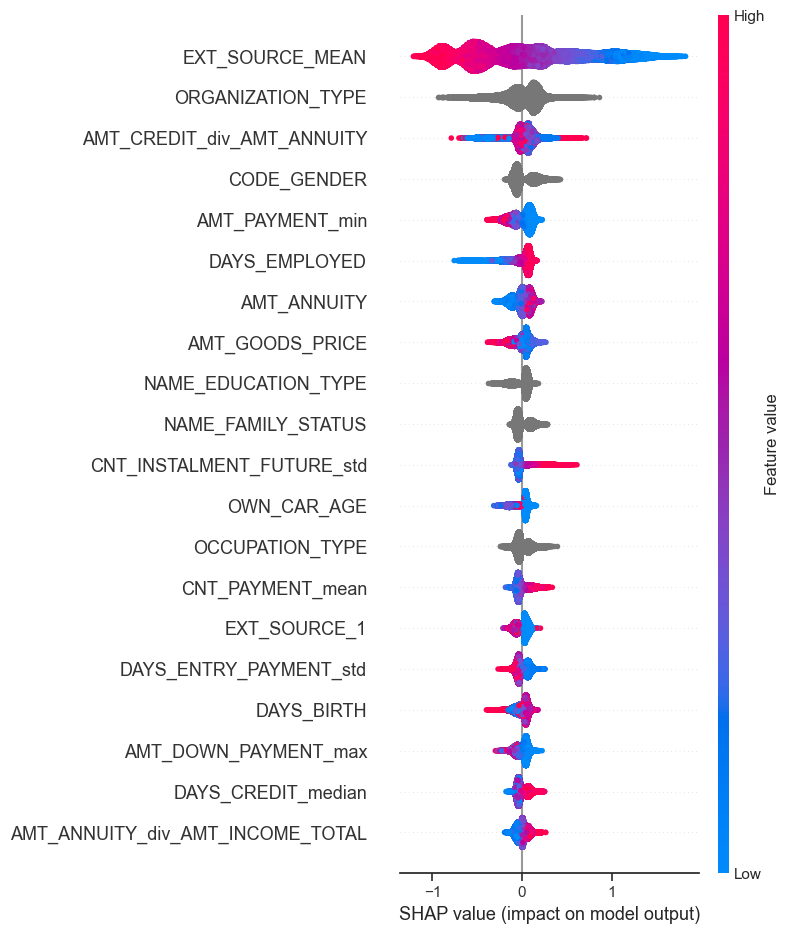

In [26]:
shap.summary_plot(shap_values_train, X_train_lgbm)

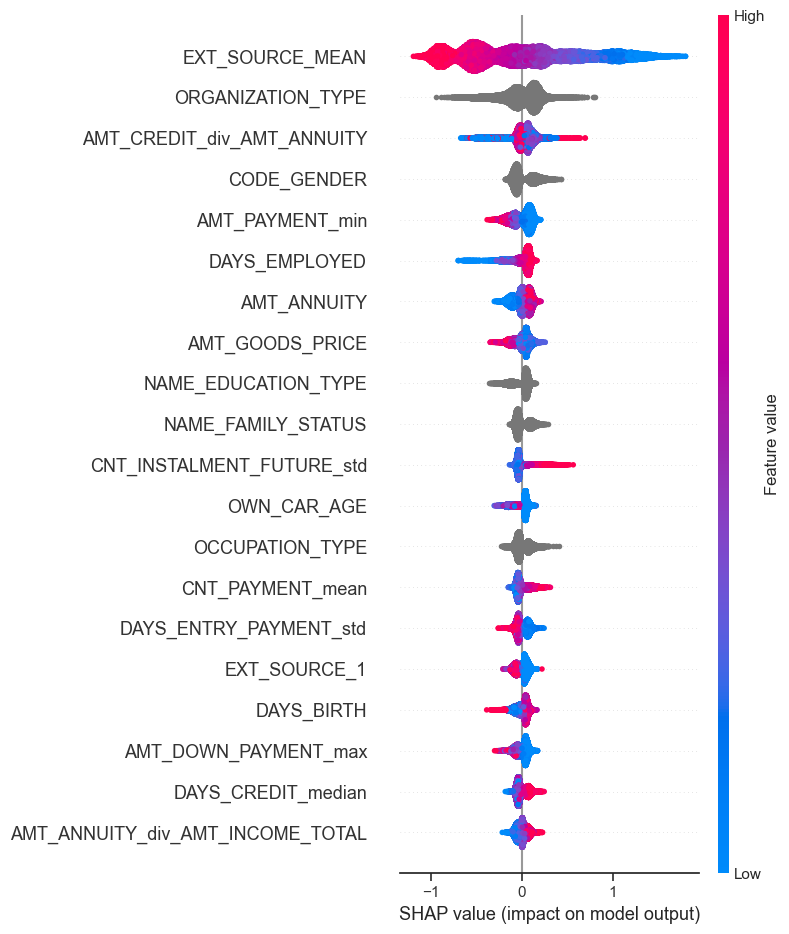

In [27]:
shap.summary_plot(shap_values_val, X_val_lgbm)

### With Boruta and Correlation Taken Into Account

In [28]:
X_train_lgbm_boruta, y_train_lgbm, scale_pos_weight_train = lgbm_preprocessing(
    X_train_full,
    y_train,
    numeric_columns=numeric_columns_boruta,
    boolean_columns=boolean_columns_boruta,
    categorical_columns=categorical_columns_boruta,
    columns_to_drop=cols_to_drop,
)
X_train_lgbm_boruta = X_train_lgbm_boruta.drop(columns=columns_to_drop_boruta_and_corr)

In [29]:
X_val_lgbm_boruta, y_val_lgbm, _ = lgbm_preprocessing(
    X_val_full,
    y_val,
    numeric_columns=numeric_columns_boruta,
    boolean_columns=boolean_columns_boruta,
    categorical_columns=categorical_columns_boruta,
    columns_to_drop=cols_to_drop,
)
X_val_lgbm_boruta = X_val_lgbm_boruta.drop(columns=columns_to_drop_boruta_and_corr)

In [30]:
lgbm_model = lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight_train)
lgbm_model.fit(
    X_train_lgbm_boruta, y_train_lgbm, categorical_feature=categorical_columns_boruta
)
lgbm_train_preds_boruta = lgbm_model.predict(X_train_lgbm_boruta)
lgbm_train_assessment_boruta = model_assessment(y_train_lgbm, lgbm_train_preds_boruta)

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31738
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
AUC-ROC: 0.7556386564138868
Accuracy: 0.7373555684277918
F1-Score: 0.32337618137550067
Precision: 0.20414504346676363
Recall: 0.7774420946626385


In [31]:
lgbm_val_preds_boruta = lgbm_model.predict(X_val_lgbm_boruta)
lgbm_val_assessment_boruta = model_assessment(y_val_lgbm, lgbm_val_preds_boruta)

AUC-ROC: 0.705733290228148
Accuracy: 0.7203365716840778
F1-Score: 0.2843769502808404
Precision: 0.17920818038804404
Recall: 0.6883182275931521


In [32]:
lgbm_model_score_list = [
    lgbm_train_assessment,
    lgbm_train_assessment_boruta,
    baseline_lgbm_assessment,
    lgbm_val_assessment,
    lgbm_val_assessment_boruta,
]

lgbm_col_names = [
    "LGBM-train",
    "LGBM-train-boruta",
    "baselineLGBM-val",
    "LGBM-val",
    "LGBM-val-boruta",
]

lgbm_model_scores = concatenate_model_scores(lgbm_model_score_list, lgbm_col_names)
lgbm_model_scores

,LGBM-train,LGBM-train-boruta,baselineLGBM-val,LGBM-val,LGBM-val-boruta
auc,0.76278,0.75564,0.70247,0.70852,0.70573
accuracy,0.74251,0.73736,0.70969,0.72503,0.72034
f1,0.33041,0.32338,0.27844,0.28798,0.28438
precision,0.20910,0.20415,0.17417,0.18205,0.17921
recall,0.78695,0.77744,0.69386,0.68882,0.68832


In [33]:
lgbm_explainer_boruta = shap.TreeExplainer(lgbm_model)
shap_values_train = lgbm_explainer_boruta(X_train_lgbm_boruta)
shap_values_val = lgbm_explainer_boruta(X_val_lgbm_boruta)

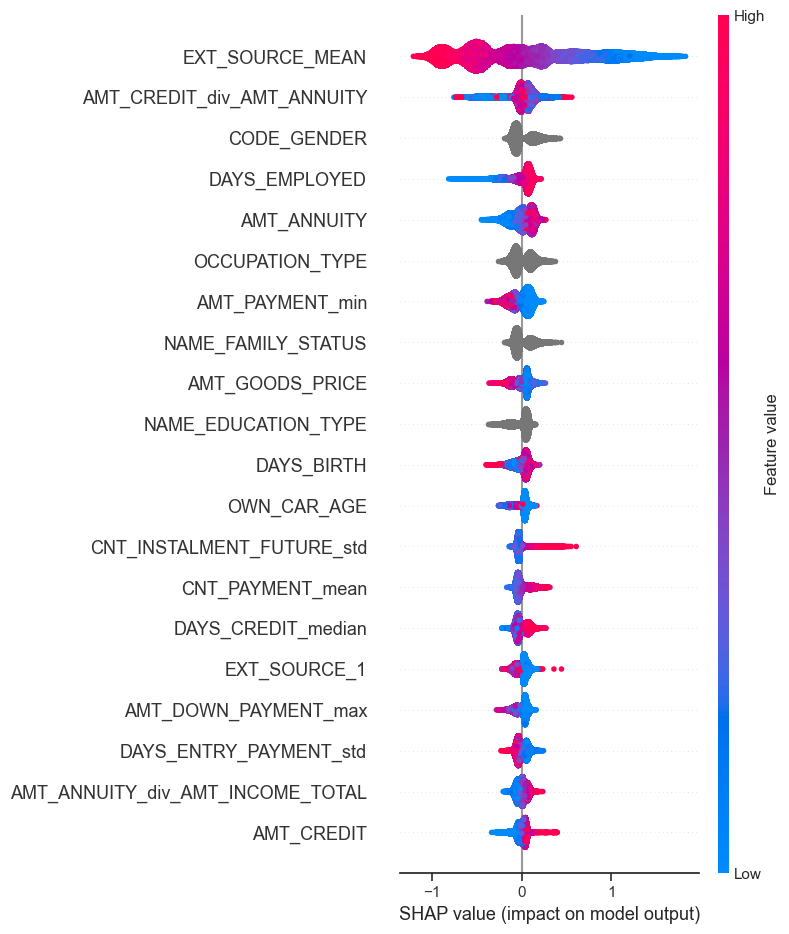

In [34]:
shap.summary_plot(shap_values_train, X_train_lgbm_boruta)

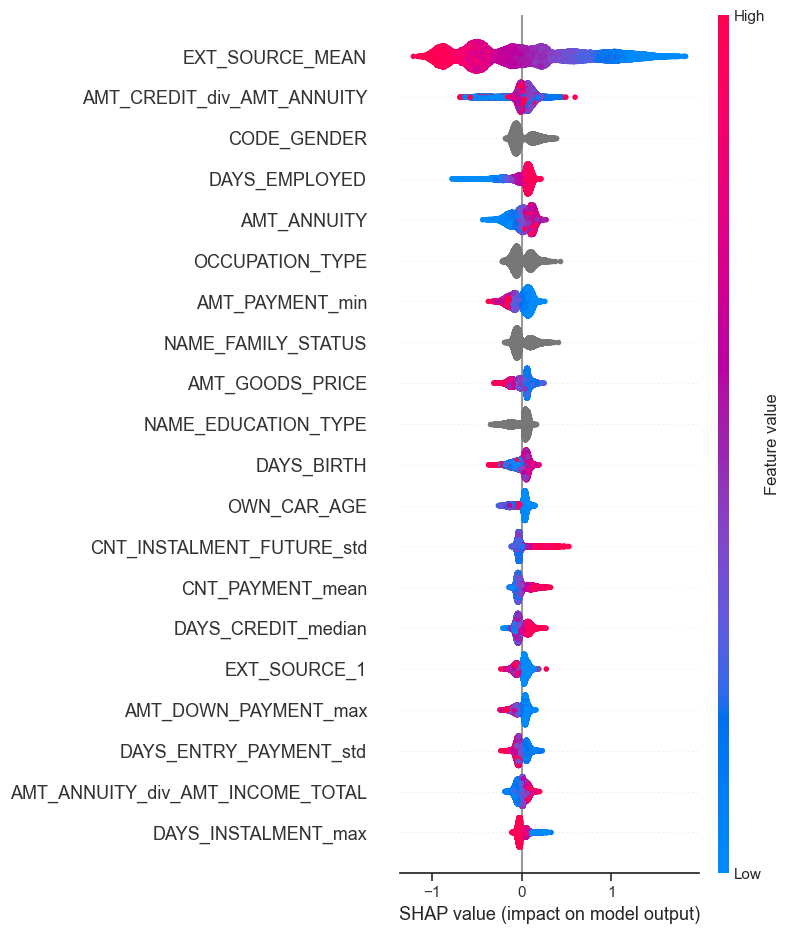

In [35]:
shap.summary_plot(shap_values_val, X_val_lgbm_boruta)

## Logistic Regression

In [36]:
X_train_lr, y_train_lr = log_reg_preprocessing(X_train_full, y_train)

In [37]:
X_val_lr, y_val_lr = log_reg_preprocessing(X_val_full, y_val)

In [38]:
log_reg_variables = ColumnTransformer(
    [
        (
            "one_hot_categoricals",
            OneHotEncoder(sparse_output=False, drop="first"),
            cat_cols,
        ),
        ("scale_numericals", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [39]:
log_reg_pipeline = Pipeline(
    steps=[
        ("encode_and_scale", log_reg_variables),
        (
            "logistic_regression",
            LogisticRegression(
                penalty="l1",
                solver="saga",
                C=0.1,
                class_weight="balanced",
                max_iter=400,
                random_state=10,
            ),
        ),
    ]
)

In [40]:
log_reg_pipeline.fit(X_train_lr, y_train_lr)
lr_train_preds = log_reg_pipeline.predict(X_train_lr)
lr_train_assessment = model_assessment(y_train_lr, lr_train_preds)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC-ROC: 0.7037542905134804
Accuracy: 0.7014979218113269
F1-Score: 0.2764702259991379
Precision: 0.17186519056150182
Recall: 0.7064451158106747


In [41]:
lr_val_preds = log_reg_pipeline.predict(X_val_lr)
lr_val_assessment = model_assessment(y_val_lr, lr_val_preds)

AUC-ROC: 0.6958433609665181
Accuracy: 0.6981423519369131
F1-Score: 0.270458787700167
Precision: 0.16800927621139997
Recall: 0.6931017119838873


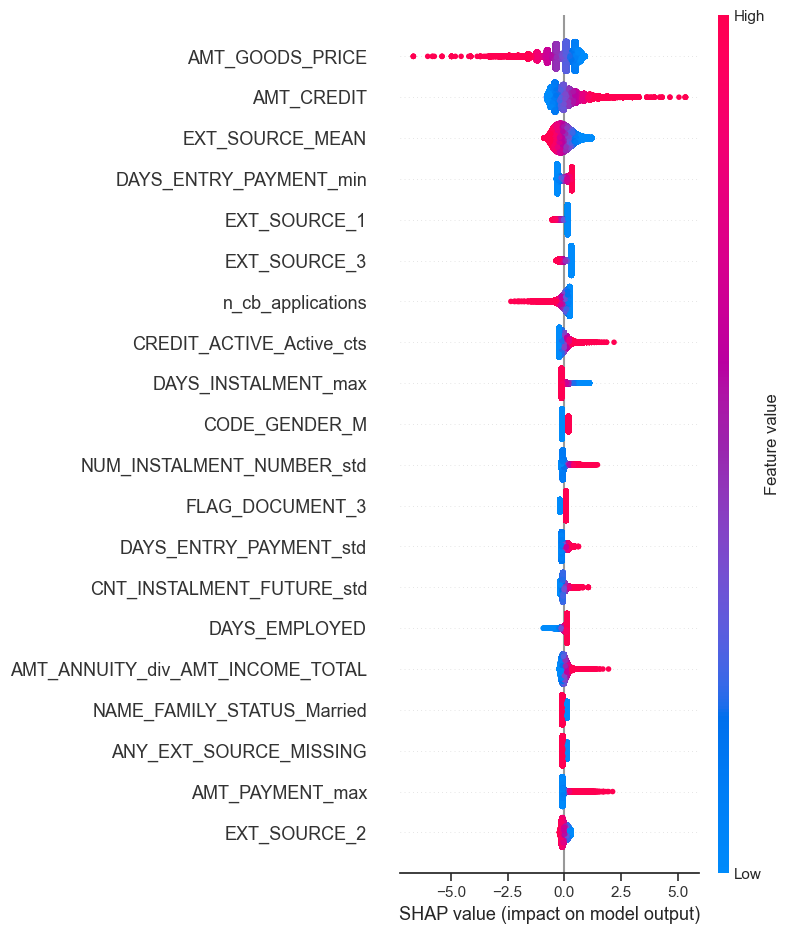

In [42]:
X_train_lr_transformed = log_reg_pipeline.named_steps["encode_and_scale"].transform(
    X_train_lr
)
X_train_lr_df = pd.DataFrame(
    X_train_lr_transformed,
    columns=log_reg_pipeline.named_steps["encode_and_scale"].get_feature_names_out(),
)

X_val_lr_transformed = log_reg_pipeline.named_steps["encode_and_scale"].transform(
    X_val_lr
)
X_val_lr_df = pd.DataFrame(
    X_val_lr_transformed,
    columns=log_reg_pipeline.named_steps["encode_and_scale"].get_feature_names_out(),
)

lr_explainer = shap.LinearExplainer(
    log_reg_pipeline.named_steps["logistic_regression"], X_train_lr_df
)
shap_values_train_lr = lr_explainer(X_train_lr_df)
shap.summary_plot(shap_values_train_lr, X_train_lr_df)

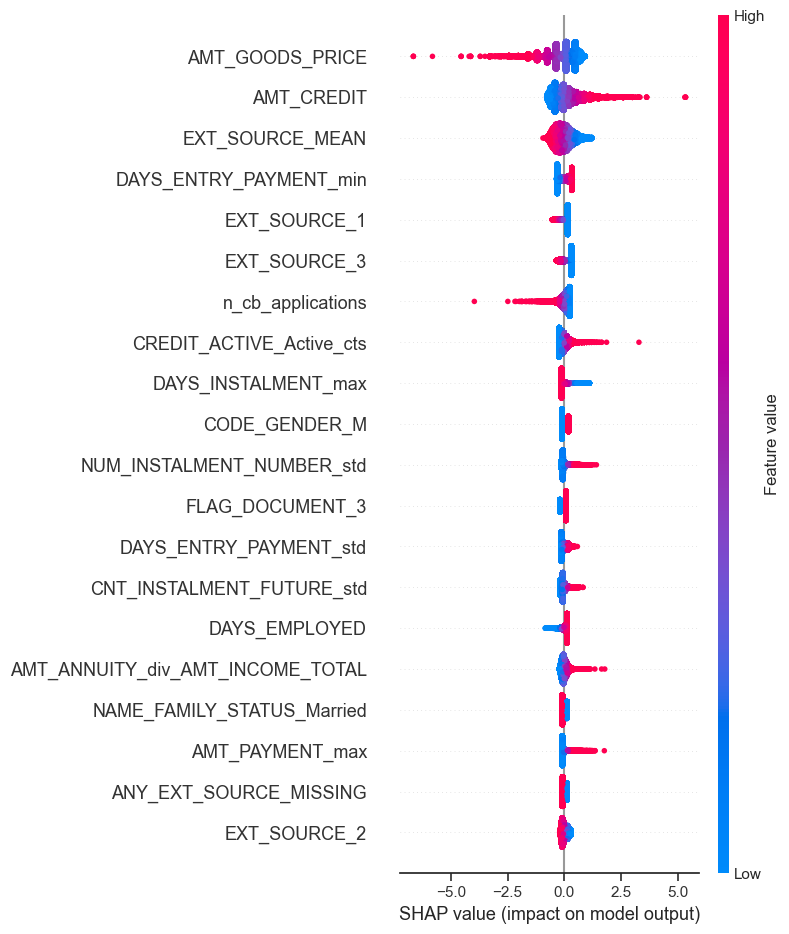

In [43]:
shap_values_val_lr = lr_explainer(X_val_lr_df)
shap.summary_plot(shap_values_val_lr, X_val_lr_df)

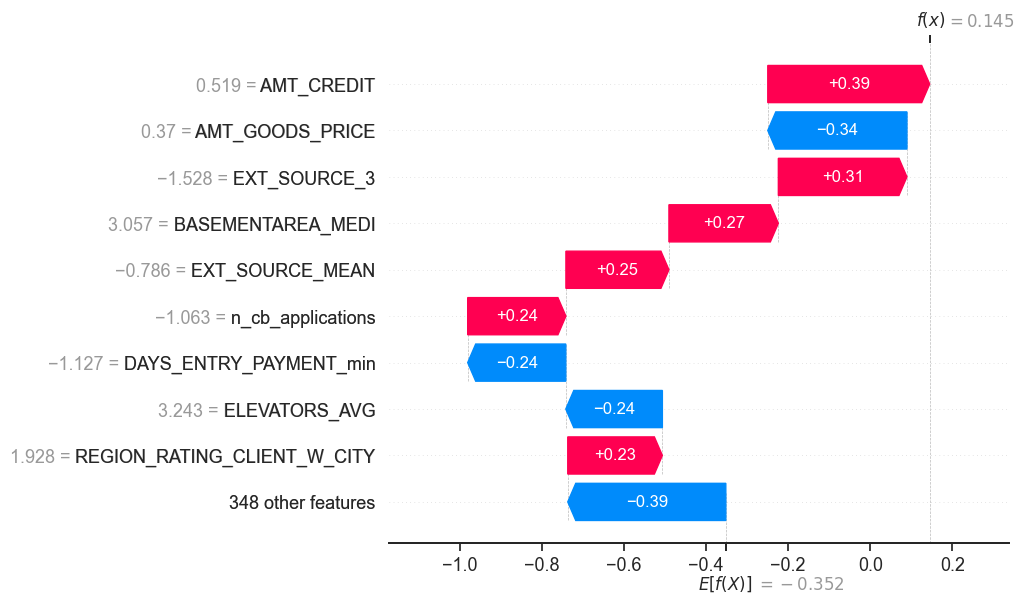

In [44]:
shap.plots.waterfall(shap_values_train_lr[0])

Note: One cool thing about SHAP is that although you can look at global feature importances as I did before with the summary plots, you can also look at how SPECIFIC instances are predicted as seen above! The direction and size of the arrows you see above tells you how much sway that particular feature has on the prediction being made.

### With Boruta and Correlation Taken Into Account

In [45]:
X_train_lr_boruta, y_train_lr_boruta = log_reg_preprocessing(
    X_train_full,
    y_train,
    numeric_columns=numeric_columns_boruta,
    boolean_columns=boolean_columns_boruta,
    categorical_columns=categorical_columns_boruta,
    columns_to_drop=cols_to_drop,
)
X_train_lr_boruta = X_train_lr_boruta.drop(columns=columns_to_drop_boruta_and_corr)

In [46]:
X_val_lr_boruta, y_val_lr_boruta = log_reg_preprocessing(
    X_val_full,
    y_val,
    numeric_columns=numeric_columns_boruta,
    boolean_columns=boolean_columns_boruta,
    categorical_columns=categorical_columns_boruta,
    columns_to_drop=cols_to_drop,
)
X_val_lr_boruta = X_val_lr_boruta.drop(columns=columns_to_drop_boruta_and_corr)

In [47]:
log_reg_variables_boruta = ColumnTransformer(
    [
        (
            "one_hot_categoricals",
            OneHotEncoder(sparse_output=False, drop="first"),
            categorical_columns_boruta,
        ),
        ("scale_numericals", StandardScaler(), numeric_columns_boruta),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
log_reg_pipeline_boruta = Pipeline(
    steps=[
        ("encode_and_scale", log_reg_variables_boruta),
        (
            "logistic_regression",
            LogisticRegression(
                penalty="l1",
                solver="saga",
                C=0.1,
                class_weight="balanced",
                max_iter=400,
                random_state=10,
            ),
        ),
    ]
)
log_reg_pipeline_boruta.fit(X_train_lr_boruta, y_train_lr_boruta)
lr_train_preds_boruta = log_reg_pipeline_boruta.predict(X_train_lr_boruta)
lr_train_assessment_boruta = model_assessment(y_train_lr_boruta, lr_train_preds_boruta)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC-ROC: 0.7024405610690614
Accuracy: 0.7000853632511204
F1-Score: 0.2751888008841407
Precision: 0.17094603872030756
Recall: 0.7052492447129909


In [48]:
lr_val_preds_boruta = log_reg_pipeline_boruta.predict(X_val_lr_boruta)
lr_val_assessment_boruta = model_assessment(y_val_lr_boruta, lr_val_preds_boruta)

AUC-ROC: 0.6952143280656392
Accuracy: 0.6952969391488151
F1-Score: 0.26918202203373304
Precision: 0.1669084753959618
Recall: 0.6951158106747231


In [49]:
lr_model_score_list = [
    lr_train_assessment,
    lr_train_assessment_boruta,
    lr_val_assessment,
    lr_val_assessment_boruta,
]

lr_col_names = [
    "Logreg-train",
    "Logreg-train-boruta",
    "Logreg-val",
    "Logreg-val-boruta",
]

lr_model_scores = concatenate_model_scores(lr_model_score_list, lr_col_names)
lr_model_scores

,Logreg-train,Logreg-train-boruta,Logreg-val,Logreg-val-boruta
auc,0.70375,0.70244,0.69584,0.69521
accuracy,0.70150,0.70009,0.69814,0.69530
f1,0.27647,0.27519,0.27046,0.26918
precision,0.17187,0.17095,0.16801,0.16691
recall,0.70645,0.70525,0.69310,0.69512


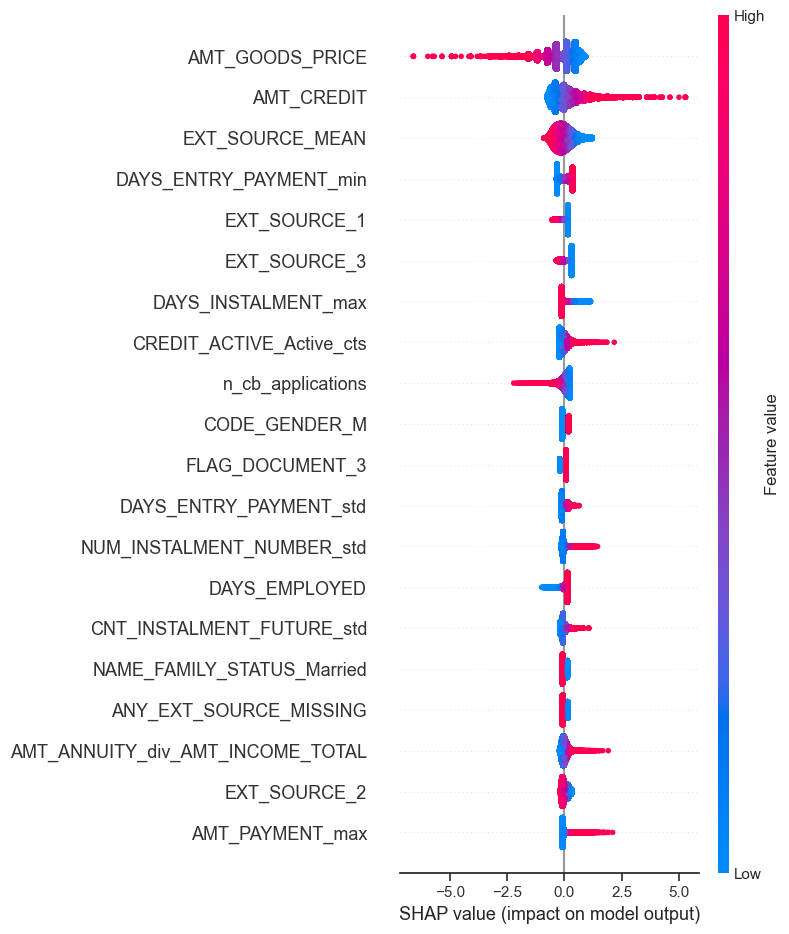

In [50]:
X_train_lr_transformed_boruta = log_reg_pipeline_boruta.named_steps[
    "encode_and_scale"
].transform(X_train_lr_boruta)
X_train_lr_df_boruta = pd.DataFrame(
    X_train_lr_transformed_boruta,
    columns=log_reg_pipeline_boruta.named_steps[
        "encode_and_scale"
    ].get_feature_names_out(),
)

X_val_lr_transformed_boruta = log_reg_pipeline_boruta.named_steps[
    "encode_and_scale"
].transform(X_val_lr_boruta)
X_val_lr_df_boruta = pd.DataFrame(
    X_val_lr_transformed_boruta,
    columns=log_reg_pipeline_boruta.named_steps[
        "encode_and_scale"
    ].get_feature_names_out(),
)

lr_explainer_boruta = shap.LinearExplainer(
    log_reg_pipeline_boruta.named_steps["logistic_regression"], X_train_lr_df_boruta
)
shap_values_train_lr_boruta = lr_explainer_boruta(X_train_lr_df_boruta)
shap.summary_plot(shap_values_train_lr_boruta, X_train_lr_df_boruta)

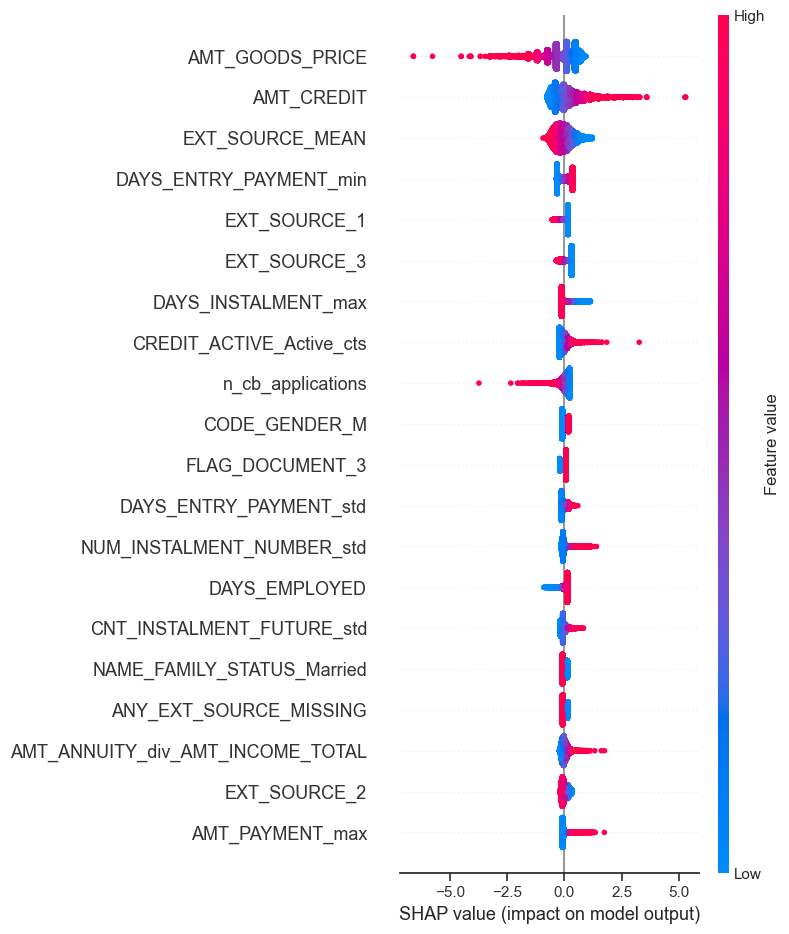

In [51]:
shap_values_val_lr_boruta = lr_explainer_boruta(X_val_lr_df_boruta)
shap.summary_plot(shap_values_val_lr_boruta, X_val_lr_df_boruta)

## Random Forest

In [52]:
X_train_rf, y_train_rf = rf_preprocessing(X_train_full, y_train)

In [53]:
X_val_rf, y_val_rf = rf_preprocessing(X_val_full, y_val)

In [54]:
rf_variables = ColumnTransformer(
    [
        (
            "one_hot_categoricals",
            OneHotEncoder(sparse_output=False),
            cat_cols,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [55]:
rf_pipeline = Pipeline(
    steps=[
        ("encode", rf_variables),
        (
            "random_forest",
            RandomForestClassifier(
                class_weight="balanced", n_estimators=100, max_depth=10, random_state=42
            ),
        ),
    ]
)
rf_pipeline.fit(X_train_rf, y_train_rf)
rf_train_preds = rf_pipeline.predict(X_train_rf)
rf_train_assessment = model_assessment(y_train_rf, rf_train_preds)

AUC-ROC: 0.757973457137648
Accuracy: 0.7784874444884811
F1-Score: 0.34838497526269374
Precision: 0.2284426149171812
Recall: 0.7335095669687814


In [56]:
rf_val_preds = rf_pipeline.predict(X_val_rf)
rf_val_assessment = model_assessment(y_val_rf, rf_val_preds)

AUC-ROC: 0.6782763336279003
Accuracy: 0.7564123409617495
F1-Score: 0.2794444778452474
Precision: 0.1835558012795198
Recall: 0.5850956696878147


In [57]:
X_train_rf_transformed = rf_pipeline.named_steps["encode"].transform(X_train_rf)
X_train_rf_df = pd.DataFrame(
    X_train_rf_transformed,
    columns=rf_pipeline.named_steps["encode"].get_feature_names_out(),
)

X_val_rf_transformed = rf_pipeline.named_steps["encode"].transform(X_val_rf)
X_val_rf_df = pd.DataFrame(
    X_val_rf_transformed,
    columns=rf_pipeline.named_steps["encode"].get_feature_names_out(),
)

In [58]:
importances = rf_pipeline[-1].feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in rf_pipeline[-1].estimators_], axis=0
)

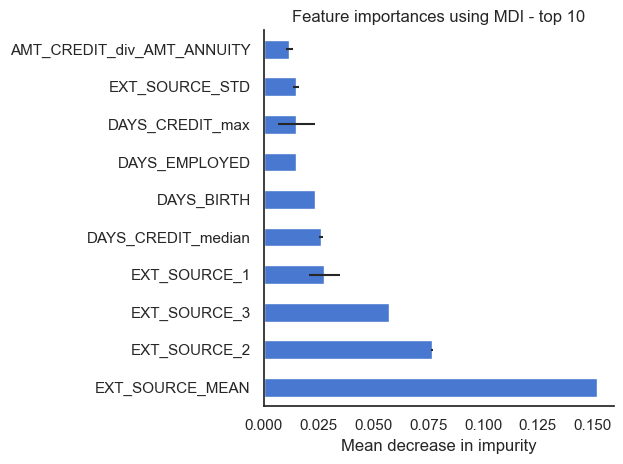

In [59]:
fig, ax = plt.subplots()
forest_importances = pd.Series(
    importances, index=rf_pipeline[-2].get_feature_names_out()
)
forest_importances = forest_importances.sort_values(ascending=False)
forest_importances_top_10 = forest_importances[0:10]
forest_importances_top_10.plot.barh(xerr=std[0:10], ax=ax)
ax.set_title("Feature importances using MDI - top 10")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

### With Boruta and Correlation Taken Into Account

In [60]:
X_train_rf_boruta, y_train_rf_boruta = rf_preprocessing(
    X_train_full,
    y_train,
    numeric_columns=numeric_columns_boruta,
    boolean_columns=boolean_columns_boruta,
    categorical_columns=categorical_columns_boruta,
    columns_to_drop=cols_to_drop,
)
X_train_rf_boruta = X_train_rf_boruta.drop(columns=columns_to_drop_boruta_and_corr)

In [61]:
X_val_rf_boruta, y_val_rf_boruta = rf_preprocessing(
    X_val_full,
    y_val,
    numeric_columns=numeric_columns_boruta,
    boolean_columns=boolean_columns_boruta,
    categorical_columns=categorical_columns_boruta,
    columns_to_drop=cols_to_drop,
)
X_val_rf_boruta = X_val_rf_boruta.drop(columns=columns_to_drop_boruta_and_corr)

In [62]:
rf_variables_boruta = ColumnTransformer(
    [
        (
            "one_hot_categoricals",
            OneHotEncoder(sparse_output=False),
            categorical_columns_boruta,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
rf_pipeline_boruta = Pipeline(
    steps=[
        ("encode", rf_variables_boruta),
        (
            "random_forest",
            RandomForestClassifier(
                class_weight="balanced", n_estimators=100, max_depth=10, random_state=42
            ),
        ),
    ]
)
rf_pipeline_boruta.fit(X_train_rf_boruta, y_train_rf_boruta)
rf_train_preds_boruta = rf_pipeline_boruta.predict(X_train_rf_boruta)
rf_train_assessment_boruta = model_assessment(y_train_rf_boruta, rf_train_preds_boruta)

AUC-ROC: 0.7593982703569299
Accuracy: 0.7825320366248997
F1-Score: 0.3520506260124446
Precision: 0.23177514203129673
Recall: 0.7318101711983888


In [63]:
rf_val_preds_boruta = rf_pipeline_boruta.predict(X_val_rf_boruta)
rf_val_assessment_boruta = model_assessment(y_val_rf_boruta, rf_val_preds_boruta)

AUC-ROC: 0.6760978296227472
Accuracy: 0.757896020486972
F1-Score: 0.27841046765204747
Precision: 0.18331206126356095
Recall: 0.5785498489425982


In [64]:
RF_model_score_list = [
    rf_train_assessment,
    rf_train_assessment_boruta,
    rf_val_assessment,
    rf_val_assessment_boruta,
]

RF_col_names = ["RF-train", "RF-train-boruta", "RF-val", "rf-val-boruta"]

RF_model_scores = concatenate_model_scores(RF_model_score_list, RF_col_names)
RF_model_scores

,RF-train,RF-train-boruta,RF-val,rf-val-boruta
auc,0.75797,0.75940,0.67828,0.67610
accuracy,0.77849,0.78253,0.75641,0.75790
f1,0.34838,0.35205,0.27944,0.27841
precision,0.22844,0.23178,0.18356,0.18331
recall,0.73351,0.73181,0.58510,0.57855


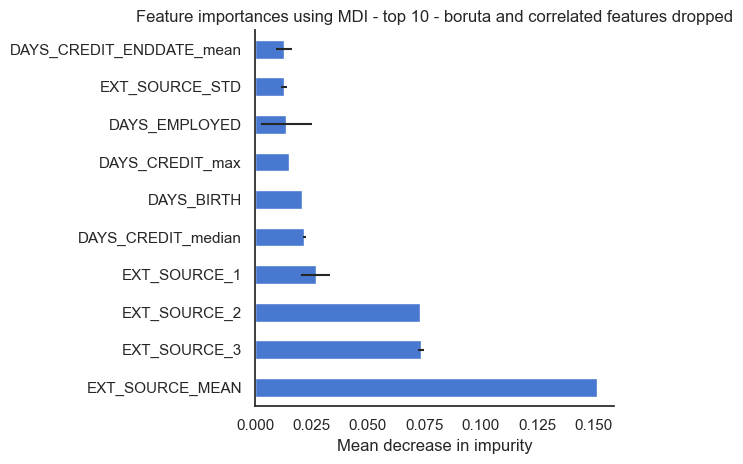

In [65]:
importances_boruta = rf_pipeline_boruta[-1].feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in rf_pipeline_boruta[-1].estimators_], axis=0
)
fig, ax = plt.subplots()
forest_importances_boruta = pd.Series(
    importances_boruta, index=rf_pipeline_boruta[-2].get_feature_names_out()
)
forest_importances_boruta = forest_importances_boruta.sort_values(ascending=False)
forest_importances_top_10_boruta = forest_importances_boruta[0:10]
forest_importances_top_10_boruta.plot.barh(xerr=std[0:10], ax=ax)
ax.set_title(
    "Feature importances using MDI - top 10 - boruta and correlated features dropped"
)
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

# Notebook Summary

In [66]:
preliminary_model_performance = pd.concat(
    [lgbm_model_scores, lr_model_scores, RF_model_scores], axis=1
)
preliminary_model_performance

,LGBM-train,LGBM-train-boruta,baselineLGBM-val,LGBM-val,LGBM-val-boruta,Logreg-train,Logreg-train-boruta,Logreg-val,Logreg-val-boruta,RF-train,RF-train-boruta,RF-val,rf-val-boruta
auc,0.76278,0.75564,0.70247,0.70852,0.70573,0.70375,0.70244,0.69584,0.69521,0.75797,0.75940,0.67828,0.67610
accuracy,0.74251,0.73736,0.70969,0.72503,0.72034,0.70150,0.70009,0.69814,0.69530,0.77849,0.78253,0.75641,0.75790
f1,0.33041,0.32338,0.27844,0.28798,0.28438,0.27647,0.27519,0.27046,0.26918,0.34838,0.35205,0.27944,0.27841
precision,0.20910,0.20415,0.17417,0.18205,0.17921,0.17187,0.17095,0.16801,0.16691,0.22844,0.23178,0.18356,0.18331
recall,0.78695,0.77744,0.69386,0.68882,0.68832,0.70645,0.70525,0.69310,0.69512,0.73351,0.73181,0.58510,0.57855


- LightGBM is the best performing model thus far, however it is potentially prone to some overfitting 
- However, logistic regression and random forest models do not perform much worse
- Random Forest models seem to potentially cause the most overfitting (see change in AUC-ROC from train to validation sets). 
- For random forest models, using fewer features produced superior results
- Across models, external sources were the strongest features used to make predictions
- The Logistic Regression model did differ from this in that it was more influenced by AMT_GOODS_PRICE and AMT_CREDIT than external source information
- Number of credit bureau applications was also an important factor 
- Perhaps more feature engineering could produce improved results. 

__in the next notebook we will dig deeper into the features with EDA and try to see what we can learn to produce superior models for deployment__

In [67]:
preliminary_model_performance.to_pickle(
    "../data/model_performance/preliminary_model_performance.pkl"
)